# LLM Factor Analysis - Personality Items (T5-GEMMA Encoder)

Extracts embeddings from DASS personality items using **T5-GEMMA encoder** and compares predicted similarities with observed correlations.

**Available Models:**
- T5-GEMMA-Base (~1B parameters, ~4 GB FP32)
- T5-GEMMA-2B (2B parameters, ~8 GB FP32)
- T5-GEMMA-9B (9B parameters, ~36 GB FP32)

**Model Configuration:**
- Precision: FP32 (full precision)
- Library: transformers (direct model access)
- Architecture: T5-based encoder-decoder (using encoder only)

**Note:** This notebook uses only the encoder portion of T5-GEMMA to extract semantic embeddings. You can easily enable/disable specific models in the model selection cell below.

## Import Dependencies

This notebook requires:
- `transformers>=4.51.0`
- `torch>=2.0.0`

In [43]:
import os
import sys

import pandas as pd
import numpy as np
print("  - pandas and numpy loaded")

import torch
print(f"  - torch {torch.__version__} loaded")

# Import transformers for T5-GEMMA
from transformers import AutoTokenizer, AutoModel
import transformers
print(f"  - transformers {transformers.__version__} loaded")

  - pandas and numpy loaded
  - torch 2.9.0 loaded
  - transformers 4.57.1 loaded


## Load and Process Data

In [44]:
print("Loading scale...")
scale = pd.read_csv('scales/DASS_items.csv', usecols=['code', 'item', 'factor'])
print(f"Loaded {len(scale)} items")

# Preview the data
scale.head()

Loading scale...
Loaded 42 items


,code,item,factor
0,S1,I found myself getting upset by quite trivial ...,Stress
1,A2,I was aware of dryness of my mouth.,Anxiety
2,D3,I couldn't seem to experience any positive fee...,Depression
3,A4,"I experienced breathing difficulty (eg, excess...",Anxiety
4,D5,I just couldn't seem to get going.,Depression


In [45]:
# Extract codes, items and factors for easier access
codes = scale['code'].tolist()
items = scale['item'].tolist()
factors = scale['factor'].tolist()

print(f"Total items: {len(items)}")
print(f"Unique factors: {sorted(set(factors))}")
print(f"Sample codes: {codes[:5]}")

Total items: 42
Unique factors: ['Anxiety', 'Depression', 'Stress']
Sample codes: ['S1', 'A2', 'D3', 'A4', 'D5']


## Device Detection and Memory Check

In [46]:
# Detect available device
print("Detecting available device...")
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"✓ Using CUDA GPU: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print("✓ Using Apple MPS GPU (Metal Performance Shaders)")
else:
    device = torch.device('cpu')
    print("✓ Using CPU")

# Check available memory (basic check)
try:
    import psutil
    mem = psutil.virtual_memory()
    print(f"\nSystem Memory:")
    print(f"  Total: {mem.total / (1024**3):.1f} GB")
    print(f"  Available: {mem.available / (1024**3):.1f} GB")
    print(f"  Used: {mem.percent}%")
except ImportError:
    print("\n  psutil not installed - skipping memory check")
    print("Install with: pip install psutil")

Detecting available device...
✓ Using Apple MPS GPU (Metal Performance Shaders)

System Memory:
  Total: 16.0 GB
  Available: 2.7 GB
  Used: 82.9%


## Configure and Load T5-GEMMA Encoder Models

**Memory Requirements (FP32 full precision):**
- T5-GEMMA-Base: ~4 GB
- T5-GEMMA-2B: ~8 GB
- T5-GEMMA-9B: ~36 GB

**How to select models:**
- In the cell below, you can easily enable/disable models by commenting/uncommenting lines
- Simply add `#` at the start of a line to disable that model
- Remove `#` to enable a model
- The notebook will automatically adapt to run 1, 2, or all 3 models

In [47]:
# ============================================================================
# MODEL SELECTION - Comment out any models you don't want to run
# ============================================================================
# To disable a model, add a '#' at the start of its line
# To enable a model, remove the '#' from the start of its line
# ============================================================================

model_names = [
    "google/t5gemma-b-b-ul2",      # Base model (~1B params, ~4 GB)
    #"google/t5gemma-2b-2b-ul2",    # 2B model (~8 GB)
    #"google/t5gemma-9b-9b-ul2",    # 9B model (~36 GB)
]

# ============================================================================

# Dictionary to store results
all_embeddings = {}
all_models = {}

print(f"Loading {len(model_names)} T5-GEMMA model(s)...")
print("=" * 70)
print(f"Selected models: {[m.split('/')[-1] for m in model_names]}")
print("=" * 70)

for model_name in model_names:
    # Extract model size from name (e.g., "b", "2b", "9b")
    model_size = model_name.split("-")[-2].upper()  # Get "b", "2b", or "9b" and uppercase
    
    print(f"\n{'='*70}")
    print(f"Loading {model_name}")
    print(f"{'='*70}")
    print(f"This may take 30-180 seconds depending on model size...")
    
    try:
        # Load tokenizer
        print("\nLoading tokenizer...")
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        print("✓ Tokenizer loaded")
        
        # Load model (encoder-decoder architecture)
        print("\nLoading model...")
        model = AutoModel.from_pretrained(
            model_name,
            dtype=torch.float32,  # FP32 full precision
        )
        
        # Move model to device
        model = model.to(device)
        model.eval()  # Set to evaluation mode
        
        print(f"✓ T5-GEMMA-{model_size} model loaded successfully!")
        print(f"  Device: {device}")
        print(f"  Model architecture: {model.__class__.__name__}")
        
        # Check embedding dimension by encoding a test string
        with torch.no_grad():
            test_inputs = tokenizer(["test"], return_tensors="pt", padding=True, truncation=True).to(device)
            test_outputs = model.encoder(**test_inputs)
            test_embedding = test_outputs.last_hidden_state[:, 0, :].cpu().numpy()  # Use first token
        
        print(f"  Embedding dimension: {test_embedding.shape[1]}")
        
        # Store the model and tokenizer
        all_models[model_size] = {"model": model, "tokenizer": tokenizer}
        
    except Exception as e:
        print(f"\nError loading {model_name}:")
        print(f"  {type(e).__name__}: {str(e)}")
        print(f"  Skipping this model and continuing with others...")
        continue

print(f"\n{'='*70}")
print(f"✓ Successfully loaded {len(all_models)} model(s)!")
print(f"{'='*70}")

Loading 1 T5-GEMMA model(s)...
Selected models: ['t5gemma-b-b-ul2']

Loading google/t5gemma-b-b-ul2
This may take 30-180 seconds depending on model size...

Loading tokenizer...
✓ Tokenizer loaded

Loading model...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


✓ T5-GEMMA-B model loaded successfully!
  Device: mps
  Model architecture: T5GemmaModel
  Embedding dimension: 768

✓ Successfully loaded 1 model(s)!


## Extract Embeddings Using Encoder

Extract embeddings for all personality items using the T5-GEMMA encoder.

**Processing:**
- Extract embeddings from encoder's last hidden state using **mean pooling**
- T5 models don't have a [CLS] token, so we average across all tokens (accounting for padding)
- Using `batch_size=8` for efficient processing
- Results stored in `all_embeddings` dictionary

In [48]:
print(f"Extracting embeddings for {len(items)} personality items using T5-GEMMA encoder...")
print("=" * 70)

for model_size, model_dict in all_models.items():
    model = model_dict["model"]
    tokenizer = model_dict["tokenizer"]
    
    print(f"\n{'='*70}")
    print(f"Processing with {model_size} model")
    print(f"{'='*70}")
    
    try:
        # Extract embeddings in batches
        batch_size = 8
        all_item_embeddings = []
        
        with torch.no_grad():
            for i in range(0, len(items), batch_size):
                batch_items = items[i:i+batch_size]
                
                # Tokenize batch
                inputs = tokenizer(
                    batch_items,
                    return_tensors="pt",
                    padding=True,
                    truncation=True,
                    max_length=512
                ).to(device)
                
                # Get encoder outputs
                outputs = model.encoder(**inputs)
                
                # Mean pooling with attention mask (T5 doesn't have [CLS] token)
                # This properly accounts for padding tokens
                attention_mask = inputs['attention_mask']
                # Expand mask to match hidden state dimensions: (batch_size, seq_len, hidden_dim)
                mask_expanded = attention_mask.unsqueeze(-1).expand(outputs.last_hidden_state.size()).float()
                # Sum embeddings (masked) across sequence dimension
                sum_embeddings = torch.sum(outputs.last_hidden_state * mask_expanded, 1)
                # Sum mask to get actual token counts (avoid division by zero)
                sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
                # Mean pooling: divide sum by count
                batch_embeddings = (sum_embeddings / sum_mask).cpu().numpy()
                
                all_item_embeddings.append(batch_embeddings)
                
                print(f"  Processed batch {i//batch_size + 1}/{(len(items)-1)//batch_size + 1}", end="\r")
        
        # Concatenate all batches
        embeddings = np.vstack(all_item_embeddings)
        
        # Normalize embeddings (L2 normalization)
        embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
        
        # Store results
        all_embeddings[model_size] = embeddings
        
        print(f"\n\n✓ Embedding extraction complete for {model_size}!")
        print(f"  Shape: {embeddings.shape}")
        print(f"  ({embeddings.shape[0]} items × {embeddings.shape[1]} dimensions)")
        
    except RuntimeError as e:
        if "out of memory" in str(e).lower():
            print(f"\nOut of memory error with {model_size}!")
            print(f"  Try reducing batch_size or using CPU")
            raise
        else:
            raise

print(f"\n{'='*70}")
print(f"✓ All embeddings extracted successfully!")
print(f"{'='*70}")
print(f"\nEmbedding dimensions by model:")
for model_size, embeddings in all_embeddings.items():
    print(f"  {model_size}: {embeddings.shape[1]}D")

Extracting embeddings for 42 personality items using T5-GEMMA encoder...

Processing with B model
  Processed batch 6/6

✓ Embedding extraction complete for B!
  Shape: (42, 768)
  (42 items × 768 dimensions)

✓ All embeddings extracted successfully!

Embedding dimensions by model:
  B: 768D


## Inspect Embedding Results

In [49]:
# Compare embedding dimensions across models
print("Embedding dimensions by model:")
print("=" * 70)
for model_size, embeddings in all_embeddings.items():
    print(f"\n{model_size}:")
    print(f"  Shape: {embeddings.shape}")
    print(f"  Embedding dimension: {embeddings.shape[1]}D")
    print(f"  First embedding (first 10 values): {embeddings[0][:10]}")

Embedding dimensions by model:

B:
  Shape: (42, 768)
  Embedding dimension: 768D
  First embedding (first 10 values): [ 0.03444629 -0.03866305  0.0200211   0.00015733  0.0184943  -0.0229909
 -0.02836667 -0.04523707 -0.08319276 -0.01196242]


In [50]:
# Summary statistics for all models
print("Embedding statistics by model:")
print("=" * 70)
for model_size, embeddings in all_embeddings.items():
    print(f"\n{model_size}:")
    print(f"  Min value: {embeddings.min():.4f}")
    print(f"  Max value: {embeddings.max():.4f}")
    print(f"  Mean: {embeddings.mean():.4f}")
    print(f"  Std: {embeddings.std():.4f}")

Embedding statistics by model:

B:
  Min value: -0.3541
  Max value: 0.2463
  Mean: -0.0009
  Std: 0.0361


In [51]:
# Check a specific item across all models
sample_idx = 0
print(f"Sample item #{sample_idx}:")
print(f"  Factor: {factors[sample_idx]}")
print(f"  Text: {items[sample_idx]}")
print("\nEmbedding properties by model:")
print("=" * 70)

for model_size, embeddings in all_embeddings.items():
    print(f"\n{model_size}:")
    print(f"  Embedding shape: {embeddings[sample_idx].shape}")
    print(f"  Embedding norm: {np.linalg.norm(embeddings[sample_idx]):.4f}")

Sample item #0:
  Factor: Stress
  Text: I found myself getting upset by quite trivial things.

Embedding properties by model:

B:
  Embedding shape: (768,)
  Embedding norm: 1.0000


## T-SNE Visualization

Visualize the high-dimensional embeddings in 2D space using T-SNE, color-coded by personality factor.

In [52]:
# Import visualization libraries
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

print("Visualization libraries loaded")

Visualization libraries loaded


In [53]:
# Prepare data for T-SNE (same across all models)
print("Preparing data for T-SNE...")
print(f"Number of items: {len(factors)}")

# Get unique factors for legend
unique_factors = sorted(set(factors))
print(f"Personality factors: {unique_factors}")

# Create a color map for the personality factors
import matplotlib.pyplot as plt
colors_map = plt.colormaps.get_cmap('tab10')
factor_to_color = {factor: colors_map(i / len(unique_factors)) for i, factor in enumerate(unique_factors)}

Preparing data for T-SNE...
Number of items: 42
Personality factors: ['Anxiety', 'Depression', 'Stress']


In [54]:
# Run T-SNE and create visualizations for all models
print("Running T-SNE for all models...")
print("=" * 70)

all_tsne_embeddings = {}

for model_key, embeddings in all_embeddings.items():
    print(f"\n{'='*70}")
    print(f"Running T-SNE for {model_key}...")
    print(f"{'='*70}")
    print(f"Input shape: {embeddings.shape}")
    
    # Run T-SNE dimensionality reduction
    tsne = TSNE(
        n_components=2,      # Reduce to 2D
        perplexity=25,       # Balance local vs global structure
        max_iter=1000,       # Number of iterations
        random_state=42,     # For reproducibility
        verbose=1            # Show progress
    )
    
    # Transform high-D embeddings to 2D
    embeddings_2d = tsne.fit_transform(embeddings)
    all_tsne_embeddings[model_key] = embeddings_2d
    
    print(f"✓ T-SNE complete! 2D embeddings shape: {embeddings_2d.shape}")

print(f"\n{'='*70}")
print(f"✓ T-SNE complete for all {len(all_tsne_embeddings)} models!")
print(f"{'='*70}")

Running T-SNE for all models...

Running T-SNE for B...
Input shape: (42, 768)
[t-SNE] Computing 41 nearest neighbors...
[t-SNE] Indexed 42 samples in 0.000s...
[t-SNE] Computed neighbors for 42 samples in 0.035s...
[t-SNE] Computed conditional probabilities for sample 42 / 42
[t-SNE] Mean sigma: 0.296197
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.840149
[t-SNE] KL divergence after 1000 iterations: 0.155570
✓ T-SNE complete! 2D embeddings shape: (42, 2)

✓ T-SNE complete for all 1 models!


Creating visualizations...
Plots will be saved to: plots/
Creating plots for 1 model(s)...

✓ Plot saved to: plots/t5gemma_tsne_visualization_B_20251022_015206.png


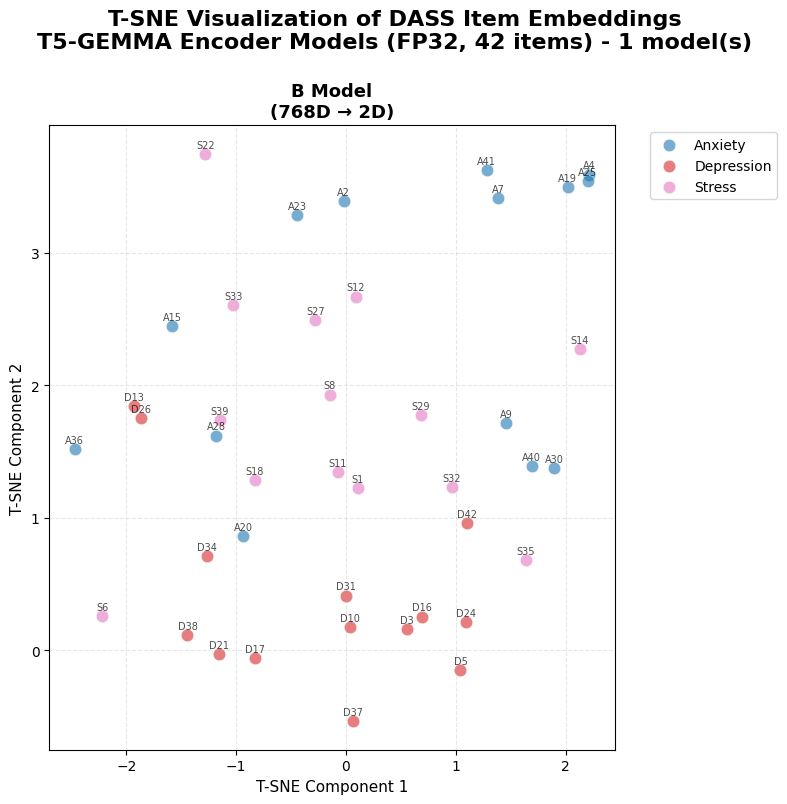


✓ Visualization complete!


In [55]:
# Create T-SNE scatter plots for all models
print("Creating visualizations...")
print("=" * 70)

# Create plots directory if it doesn't exist
import os
from datetime import datetime

plots_dir = "plots"
os.makedirs(plots_dir, exist_ok=True)
print(f"Plots will be saved to: {plots_dir}/")

# Generate timestamp for filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Determine number of models and create appropriate figure
num_models = len(all_tsne_embeddings)
print(f"Creating plots for {num_models} model(s)...")

# Check if we have any models to plot
if num_models == 0:
    print("\n⚠ WARNING: No T-SNE embeddings available to plot!")
    print("  This could mean:")
    print("  - No models were successfully loaded")
    print("  - Embedding extraction failed for all models")
    print("  - T-SNE failed for all models")
    print("\nSkipping visualization...")
else:
    # Adjust figure size based on number of models
    fig_width = 8 * num_models  # 8 inches per model
    fig, axes = plt.subplots(1, num_models, figsize=(fig_width, 8))
    
    # Handle case of single model (axes is not a list in this case)
    if num_models == 1:
        axes = [axes]
    
    for idx, (model_key, embeddings_2d) in enumerate(sorted(all_tsne_embeddings.items())):
        ax = axes[idx]
        
        # Plot each factor with a different color
        for factor in unique_factors:
            # Get indices for this factor
            indices = [i for i, f in enumerate(factors) if f == factor]
            
            # Plot points for this factor
            ax.scatter(
                embeddings_2d[indices, 0],
                embeddings_2d[indices, 1],
                c=[factor_to_color[factor]],
                label=factor,
                alpha=0.6,
                s=80,
                edgecolors='white',
                linewidth=0.5
            )
        
        # Add labels for each point using the 'code' column
        for i in range(len(embeddings_2d)):
            ax.annotate(
                codes[i],  # Use the code as the label
                (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                fontsize=7,
                alpha=0.7,
                ha='center',
                va='bottom',
                xytext=(0, 3),  # Offset label slightly above the point
                textcoords='offset points'
            )
        
        # Get embedding dimension for title
        embedding_dim = all_embeddings[model_key].shape[1]
        
        ax.set_xlabel('T-SNE Component 1', fontsize=11)
        ax.set_ylabel('T-SNE Component 2', fontsize=11)
        ax.set_title(
            f'{model_key} Model\n({embedding_dim}D → 2D)',
            fontsize=13,
            fontweight='bold'
        )
        ax.grid(True, alpha=0.3, linestyle='--')
        
        # Add legend to the rightmost plot
        if idx == num_models - 1:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    
    # Overall title
    fig.suptitle(
        'T-SNE Visualization of DASS Item Embeddings\n'
        f'T5-GEMMA Encoder Models (FP32, {len(items)} items) - {num_models} model(s)',
        fontsize=16,
        fontweight='bold',
        y=1.00
    )
    
    plt.tight_layout()
    
    # Save the figure
    model_names_str = "_".join(sorted(all_tsne_embeddings.keys()))
    filename = f"t5gemma_tsne_visualization_{model_names_str}_{timestamp}.png"
    filepath = os.path.join(plots_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"\n✓ Plot saved to: {filepath}")
    
    # Display the plot
    plt.show()
    
    print("\n✓ Visualization complete!")

## Analyze Nearest Neighbors

Compare how the encoder embeddings identify semantic neighbors.

In [56]:
# Analyze nearest neighbors in the ORIGINAL high-dimensional space for all models
print("Finding nearest neighbors in original embedding space (not T-SNE)...")
print("=" * 70)

from sklearn.metrics.pairwise import cosine_similarity

print(f"\nSample item #{sample_idx}:")
print(f"  Factor: {factors[sample_idx]}")
print(f"  Text: {items[sample_idx]}")

for model_size, embeddings in sorted(all_embeddings.items()):
    print(f"\n{'='*70}")
    print(f"{model_size} Model - Original {embeddings.shape[1]}D Space")
    print(f"{'='*70}")
    
    # Compute cosine similarity between sample and all items
    similarities = cosine_similarity([embeddings[sample_idx]], embeddings)[0]
    
    # Find 5 most similar items (excluding itself)
    most_similar_indices = np.argsort(similarities)[::-1][1:6]
    
    print(f"5 Most similar items (by cosine similarity):")
    for rank, idx in enumerate(most_similar_indices, 1):
        print(f"  {rank}. [{factors[idx]}] {items[idx]}")
        print(f"      Similarity: {similarities[idx]:.4f}")

Finding nearest neighbors in original embedding space (not T-SNE)...

Sample item #0:
  Factor: Stress
  Text: I found myself getting upset by quite trivial things.

B Model - Original 768D Space
5 Most similar items (by cosine similarity):
  1. [Stress] I found myself getting upset rather easily.
      Similarity: 0.8868
  2. [Stress] I found myself getting agitated.
      Similarity: 0.8605
  3. [Stress] I felt that I was rather touchy.
      Similarity: 0.8445
  4. [Stress] I found it hard to calm down after something upset me.
      Similarity: 0.8423
  5. [Anxiety] I feared that I would be "thrown" by some trivial but unfamiliar task.
      Similarity: 0.8333


## Quantify Factor Separation

Measure how well the embeddings separate the three DASS factors (Anxiety, Depression, Stress) using cosine similarity analysis.

**Metrics:**
- **Within-factor similarity**: Average cosine similarity between items in the same factor
- **Between-factor similarity**: Average cosine similarity between items in different factors  
- **Separation ratio**: Within / Between (higher = better separation, >1.0 means factors cluster together)

In [57]:
print("Computing factor separation metrics...")
print("=" * 70)

# Loop through all models
for model_size, embeddings in sorted(all_embeddings.items()):
    print(f"\n{'='*70}")
    print(f"{model_size} Model - Factor Separation Analysis")
    print(f"{'='*70}")
    
    # Compute full similarity matrix
    sim_matrix = cosine_similarity(embeddings)
    
    # Initialize accumulators
    within_factor_sims = {factor: [] for factor in unique_factors}
    between_factor_sims = []
    
    # Compute within-factor and between-factor similarities
    for i in range(len(items)):
        for j in range(i + 1, len(items)):  # Only upper triangle (avoid duplicates)
            similarity = sim_matrix[i, j]
            
            if factors[i] == factors[j]:
                # Same factor - within-factor similarity
                within_factor_sims[factors[i]].append(similarity)
            else:
                # Different factors - between-factor similarity
                between_factor_sims.append(similarity)
    
    # Compute overall metrics
    all_within_sims = []
    for factor_sims in within_factor_sims.values():
        all_within_sims.extend(factor_sims)
    
    within_mean = np.mean(all_within_sims)
    between_mean = np.mean(between_factor_sims)
    separation_ratio = within_mean / between_mean
    
    # Print overall results
    print(f"\nOverall Separation Metrics:")
    print(f"  Within-factor similarity:  {within_mean:.4f}")
    print(f"  Between-factor similarity: {between_mean:.4f}")
    print(f"  Separation ratio:          {separation_ratio:.4f}")
    print(f"    {'(Good separation - factors cluster together!)' if separation_ratio > 1.0 else '(Poor separation - factors overlap)'}")
    
    # Print per-factor breakdown
    print(f"\nPer-Factor Within-Similarity:")
    for factor in unique_factors:
        factor_mean = np.mean(within_factor_sims[factor])
        factor_std = np.std(within_factor_sims[factor])
        n_pairs = len(within_factor_sims[factor])
        print(f"  {factor:12s}: {factor_mean:.4f} ± {factor_std:.4f}  (n={n_pairs} pairs)")
    
    # Compute pairwise between-factor similarities
    print(f"\nBetween-Factor Similarities:")
    factor_pairs = {}
    for i in range(len(items)):
        for j in range(i + 1, len(items)):
            if factors[i] != factors[j]:
                pair = tuple(sorted([factors[i], factors[j]]))
                if pair not in factor_pairs:
                    factor_pairs[pair] = []
                factor_pairs[pair].append(sim_matrix[i, j])
    
    for pair in sorted(factor_pairs.keys()):
        pair_mean = np.mean(factor_pairs[pair])
        pair_std = np.std(factor_pairs[pair])
        n_pairs = len(factor_pairs[pair])
        print(f"  {pair[0]:12s} vs {pair[1]:12s}: {pair_mean:.4f} ± {pair_std:.4f}  (n={n_pairs} pairs)")

print(f"\n{'='*70}")
print("Factor separation analysis complete!")
print(f"{'='*70}")

Computing factor separation metrics...

B Model - Factor Separation Analysis

Overall Separation Metrics:
  Within-factor similarity:  0.7720
  Between-factor similarity: 0.7486
  Separation ratio:          1.0313
    (Good separation - factors cluster together!)

Per-Factor Within-Similarity:
  Anxiety     : 0.7367 ± 0.0858  (n=91 pairs)
  Depression  : 0.8043 ± 0.0437  (n=91 pairs)
  Stress      : 0.7749 ± 0.0551  (n=91 pairs)

Between-Factor Similarities:
  Anxiety      vs Depression  : 0.7350 ± 0.0644  (n=196 pairs)
  Anxiety      vs Stress      : 0.7357 ± 0.0747  (n=196 pairs)
  Depression   vs Stress      : 0.7751 ± 0.0451  (n=196 pairs)

Factor separation analysis complete!


## Calculate Factor Centroids

Compute the mean embedding (centroid) for each of the three DASS factors. These centroids represent the "average" embedding for each psychological dimension and can be used for further analysis.

In [58]:
print("Calculating factor centroids...")
print("=" * 70)

# Dictionary to store centroids for all models
all_centroids = {}

# Loop through all models
for model_size, embeddings in sorted(all_embeddings.items()):
    print(f"\n{'='*70}")
    print(f"{model_size} Model - Computing Centroids")
    print(f"{'='*70}")
    
    # Initialize centroid dictionary for this model
    centroids = {}
    
    # Calculate centroid (mean embedding) for each factor
    for factor in unique_factors:
        # Get indices of items belonging to this factor
        factor_indices = [i for i, f in enumerate(factors) if f == factor]
        
        # Get embeddings for this factor
        factor_embeddings = embeddings[factor_indices]
        
        # Compute centroid (mean of all embeddings in this factor)
        centroid = np.mean(factor_embeddings, axis=0)
        
        # Store centroid
        centroids[factor] = centroid
        
        # Print info
        print(f"\n{factor}:")
        print(f"  Number of items: {len(factor_indices)}")
        print(f"  Centroid shape: {centroid.shape}")
        print(f"  Centroid norm: {np.linalg.norm(centroid):.4f}")
    
    # Store centroids for this model
    all_centroids[model_size] = centroids

print(f"\n{'='*70}")
print("Centroid calculation complete!")
print(f"{'='*70}")
print(f"\nCentroids stored in 'all_centroids' dictionary:")
print(f"  Structure: all_centroids[model_size][factor] = centroid_vector")
print(f"  Models: {list(all_centroids.keys())}")
print(f"  Factors per model: {list(all_centroids[list(all_centroids.keys())[0]].keys())}")

Calculating factor centroids...

B Model - Computing Centroids

Anxiety:
  Number of items: 14
  Centroid shape: (768,)
  Centroid norm: 0.8692

Depression:
  Number of items: 14
  Centroid shape: (768,)
  Centroid norm: 0.9046

Stress:
  Number of items: 14
  Centroid shape: (768,)
  Centroid norm: 0.8894

Centroid calculation complete!

Centroids stored in 'all_centroids' dictionary:
  Structure: all_centroids[model_size][factor] = centroid_vector
  Models: ['B']
  Factors per model: ['Anxiety', 'Depression', 'Stress']


## Decode Factor Centroids into Labels

Now we'll use the T5-GEMMA decoder to generate text labels for each factor centroid.

**Approach:**
- Load the full encoder-decoder models (with language modeling heads)
- Encode a task prompt: "describe this factor:"
- Append each factor centroid as an additional encoder token
- Use the decoder to generate a short descriptive label

This approach treats the centroid as a semantic representation that the decoder can "read" and describe in natural language.

In [59]:
# Import Seq2Seq model class for text generation
from transformers import AutoModelForSeq2SeqLM

print("Loading encoder-decoder models for centroid decoding...")
print("=" * 70)

# Dictionary to store decoder models
all_decoder_models = {}

# Load Seq2Seq models for all enabled model sizes
for model_name in model_names:
    # Extract model size from name (e.g., "b", "2b", "9b")
    model_size = model_name.split("-")[-2].upper()  # Get "b", "2b", or "9b" and uppercase
    
    print(f"\n{'='*70}")
    print(f"Loading Seq2Seq model: {model_name}")
    print(f"{'='*70}")
    print(f"This may take 30-180 seconds depending on model size...")
    
    try:
        # Load full encoder-decoder model with LM head
        print("\nLoading encoder-decoder model with LM head...")
        decoder_model = AutoModelForSeq2SeqLM.from_pretrained(
            model_name,
            torch_dtype=torch.float32,  # FP32 full precision
        )
        
        # Move model to device
        decoder_model = decoder_model.to(device)
        decoder_model.eval()  # Set to evaluation mode
        
        print(f"✓ T5-GEMMA-{model_size} Seq2Seq model loaded successfully!")
        print(f"  Device: {device}")
        print(f"  Model architecture: {decoder_model.__class__.__name__}")
        
        # Store the decoder model (tokenizer already loaded in all_models)
        all_decoder_models[model_size] = decoder_model
        
    except Exception as e:
        print(f"\nError loading {model_name}:")
        print(f"  {type(e).__name__}: {str(e)}")
        print(f"  Skipping this model and continuing with others...")
        continue

print(f"\n{'='*70}")
print(f"✓ Successfully loaded {len(all_decoder_models)} Seq2Seq model(s)!")
print(f"{'='*70}")

Loading encoder-decoder models for centroid decoding...

Loading Seq2Seq model: google/t5gemma-b-b-ul2
This may take 30-180 seconds depending on model size...

Loading encoder-decoder model with LM head...
✓ T5-GEMMA-B Seq2Seq model loaded successfully!
  Device: mps
  Model architecture: T5GemmaForConditionalGeneration

✓ Successfully loaded 1 Seq2Seq model(s)!


In [60]:
# Clean up redundant encoder-only models to free memory
import gc

print("Removing encoder-only models (Seq2Seq models contain encoders)...")

# Delete encoder-only models from all_models
for model_size in list(all_models.keys()):
    if "model" in all_models[model_size]:
        del all_models[model_size]["model"]
        print(f"  ✓ Deleted encoder model: {model_size}")

# Run garbage collection
gc.collect()

# Clear GPU cache
if device.type == "mps":
    torch.mps.empty_cache()
elif device.type == "cuda":
    torch.cuda.empty_cache()

print("✓ Cleanup complete!")

Removing encoder-only models (Seq2Seq models contain encoders)...
  ✓ Deleted encoder model: B
✓ Cleanup complete!


In [61]:
# Import necessary class for encoder outputs
from transformers.modeling_outputs import BaseModelOutput

def decode_centroid(centroid_vec, decoder_model, tokenizer, encoder_model, task_prompt="describe this factor:"):
    """
    Feeds a centroid (numpy array) into the decoder as encoder hidden state.

    The centroid is appended to the task prompt's encoder embeddings to condition the generation.

    Args:
        centroid_vec: numpy array of shape (hidden_dim,)
        decoder_model: AutoModelForSeq2SeqLM instance
        tokenizer: tokenizer for the model
        encoder_model: encoder model to encode the task prompt (same as decoder_model for Seq2Seq)
        task_prompt: text prompt to condition the generation

    Returns:
        str: decoded label text
    """
    with torch.no_grad():
        # Encode the task prompt using the encoder
        prompt_inputs = tokenizer(task_prompt, return_tensors="pt", padding=True, truncation=True).to(device)
        
        # Get encoder from Seq2Seq model and run it
        encoder = encoder_model.get_encoder()
        prompt_encoder_outputs = encoder(**prompt_inputs)
        prompt_embeddings = prompt_encoder_outputs.last_hidden_state  # shape: (1, prompt_seq_len, hidden_dim)

        # Convert centroid to proper encoder hidden-state tensor
        centroid_tensor = torch.tensor(centroid_vec, dtype=torch.float32, device=device)
        centroid_tensor = centroid_tensor.unsqueeze(0).unsqueeze(0)  # shape: (batch=1, seq_len=1, hidden_dim)

        # Concatenate prompt embeddings + centroid along sequence dimension
        combined_embeddings = torch.cat([prompt_embeddings, centroid_tensor], dim=1)  # shape: (1, prompt_seq_len+1, hidden_dim)

        # Create attention mask for the combined sequence
        attention_mask = torch.ones(combined_embeddings.shape[:2], dtype=torch.long, device=device)  # shape: (1, seq_len)

        # Wrap into BaseModelOutput dataclass expected by model.generate()
        encoder_outputs = BaseModelOutput(last_hidden_state=combined_embeddings)

        # Create proper decoder_input_ids (T5 models need this to start generation)
        # Use pad_token_id as the starting token (standard for T5)
        decoder_start_token_id = decoder_model.config.decoder_start_token_id or tokenizer.pad_token_id
        decoder_input_ids = torch.tensor([[decoder_start_token_id]], dtype=torch.long, device=device)

        # Generate label text
        outputs = decoder_model.generate(
            encoder_outputs=encoder_outputs,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            max_new_tokens=10,
            num_beams=5,
            do_sample=False,
            temperature=1.0,
            early_stopping=True
        )

        # Decode output text
        decoded_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        return decoded_text.strip()

print("✓ decode_centroid function defined")

✓ decode_centroid function defined


In [62]:
# Generate labels for all factor centroids across all models
print("Decoding factor centroids into text labels...")
print("=" * 70)

# Dictionary to store factor labels for all models
all_factor_labels = {}

# Loop through each enabled model
for model_size in sorted(all_decoder_models.keys()):
    print(f"\n{'='*70}")
    print(f"{model_size} Model - Decoding Centroids")
    print(f"{'='*70}")
    
    # Get components for this model
    decoder_model = all_decoder_models[model_size]
    # Use decoder_model as encoder (Seq2Seq models contain encoders)
    encoder_model = decoder_model
    tokenizer = all_models[model_size]["tokenizer"]
    centroids = all_centroids[model_size]
    
    # Initialize dictionary for this model's labels
    factor_labels = {}
    
    # Decode each factor centroid
    for factor, centroid_vec in sorted(centroids.items()):
        print(f"\nDecoding centroid for factor: {factor}")
        
        try:
            # Decode the centroid
            label = decode_centroid(
                centroid_vec=centroid_vec,
                decoder_model=decoder_model,
                tokenizer=tokenizer,
                encoder_model=encoder_model,
                task_prompt="describe this factor:"
            )
            
            # Store the label
            factor_labels[factor] = label
            
            print(f"  Predicted Label: {label}")
            
        except Exception as e:
            print(f"  Error decoding centroid: {type(e).__name__}: {str(e)}")
            factor_labels[factor] = "[ERROR]"
    
    # Store labels for this model
    all_factor_labels[model_size] = factor_labels

print(f"\n{'='*70}")
print("✓ Decoding complete for all models!")
print(f"{'='*70}")

# Show summary
print("\nGenerated Factor Labels Summary:")
print("=" * 70)
for model_size in sorted(all_factor_labels.keys()):
    print(f"\n{model_size} Model:")
    for factor, label in sorted(all_factor_labels[model_size].items()):
        print(f"  {factor:12s} → {label}")

Decoding factor centroids into text labels...

B Model - Decoding Centroids

Decoding centroid for factor: Anxiety
  Predicted Label: , function() {
  this.name =

Decoding centroid for factor: Depression
  Predicted Label: , function() {
  this.name =

Decoding centroid for factor: Stress
  Predicted Label: , function() {
  this.name =

✓ Decoding complete for all models!

Generated Factor Labels Summary:

B Model:
  Anxiety      → , function() {
  this.name =
  Depression   → , function() {
  this.name =
  Stress       → , function() {
  this.name =


## Generate Factor Labels from Actual Item Text (Text-Based Approach)

This alternative approach generates factor labels using the actual item text rather than feeding centroid vectors to the decoder.

**Approach:**
- For each factor, concatenate all the items that belong to that factor
- Pass this concatenated text through the encoder normally
- Use the decoder to generate a short descriptive label
- This uses the model as it was designed: text-in, text-out

In [63]:
def generate_label_from_items(factor_items, decoder_model, tokenizer, task_prompt):
    """
    Generate a factor label from actual item text using text-to-text generation.
    
    Args:
        factor_items: list of strings (the items belonging to this factor)
        decoder_model: AutoModelForSeq2SeqLM instance
        tokenizer: tokenizer for the model
        task_prompt: instruction prompt for the model
        
    Returns:
        str: generated label text
    """
    with torch.no_grad():
        # Concatenate items with separators
        items_text = " | ".join(factor_items)
        
        # Create full input text
        input_text = f"{task_prompt} {items_text}"
        
        # Tokenize input (truncate if too long)
        inputs = tokenizer(
            input_text,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512  # Limit input length
        ).to(device)
        
        # Generate label text
        outputs = decoder_model.generate(
            **inputs,
            max_new_tokens=10,
            num_beams=5,
            do_sample=False,
            temperature=1.0,
            early_stopping=True
        )
        
        # Decode output text
        decoded_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        return decoded_text.strip()

print("✓ generate_label_from_items function defined")

✓ generate_label_from_items function defined


In [64]:
# Generate labels from actual item text for all factors across all models
print("Generating factor labels from actual item text...")
print("=" * 70)

# Dictionary to store text-based factor labels for all models
text_based_factor_labels = {}

# Loop through each enabled model
for model_size in sorted(all_decoder_models.keys()):
    print(f"\n{'='*70}")
    print(f"{model_size} Model - Text-Based Label Generation")
    print(f"{'='*70}")
    
    # Get components for this model
    decoder_model = all_decoder_models[model_size]
    tokenizer = all_models[model_size]["tokenizer"]
    
    # Initialize dictionary for this model's labels
    factor_labels = {}
    
    # Generate label for each factor
    for factor in sorted(unique_factors):
        print(f"\nGenerating label for factor: {factor}")
        
        # Get all items belonging to this factor
        factor_items = [items[i] for i, f in enumerate(factors) if f == factor]
        print(f"  Number of items: {len(factor_items)}")

        print(factor_items)
        
        try:
            # Generate the label from concatenated items
            label = generate_label_from_items(
                factor_items=factor_items,
                decoder_model=decoder_model,
                tokenizer=tokenizer,
                task_prompt="Given this list of input text, the common ONE-WORD theme is:"
            )
            
            # Store the label
            factor_labels[factor] = label
            
            print(f"  Generated Label: {label}")
            
        except Exception as e:
            print(f"  Error generating label: {type(e).__name__}: {str(e)}")
            factor_labels[factor] = "[ERROR]"
    
    # Store labels for this model
    text_based_factor_labels[model_size] = factor_labels

Generating factor labels from actual item text...

B Model - Text-Based Label Generation

Generating label for factor: Anxiety
  Number of items: 14
['I was aware of dryness of my mouth.', 'I experienced breathing difficulty (eg, excessively rapid breathing, breathlessness in the absence of physical exertion).', 'I had a feeling of shakiness (eg, legs going to give way).', 'I found myself in situations that made me so anxious I was most relieved when they ended.', 'I had a feeling of faintness.', 'I perspired noticeably (eg, hands sweaty) in the absence of high temperatures or physical exertion.', 'I felt scared without any good reason.', 'I had difficulty in swallowing.', 'I was aware of the action of my heart in the absence of physical exertion (eg, sense of heart rate increase, heart missing a beat).', 'I felt I was close to panic.', 'I feared that I would be "thrown" by some trivial but unfamiliar task.', 'I felt terrified.', 'I was worried about situations in which I might panic a